<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Где-брать-данные?" data-toc-modified-id="Где-брать-данные?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Где брать данные?</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Какие-бывают-значения-рейтинга?" data-toc-modified-id="Какие-бывают-значения-рейтинга?-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Какие бывают значения рейтинга?</a></span></li><li><span><a href="#Добавьте-целевую-переменную" data-toc-modified-id="Добавьте-целевую-переменную-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Добавьте целевую переменную</a></span></li><li><span><a href="#Худший-и-лучший-банк" data-toc-modified-id="Худший-и-лучший-банк-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Худший и лучший банк</a></span></li><li><span><a href="#Отличается-ли-длина-у-хороших-и-плохих-отзывов?" data-toc-modified-id="Отличается-ли-длина-у-хороших-и-плохих-отзывов?-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Отличается ли длина у хороших и плохих отзывов?</a></span></li><li><span><a href="#Отличается-ли-распределение-количества-восклицательных-знаков?" data-toc-modified-id="Отличается-ли-распределение-количества-восклицательных-знаков?-2.0.5"><span class="toc-item-num">2.0.5&nbsp;&nbsp;</span>Отличается ли распределение количества восклицательных знаков?</a></span></li></ul></li></ul></li><li><span><a href="#Бейзлайн-модель-классификации" data-toc-modified-id="Бейзлайн-модель-классификации-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Бейзлайн модель классификации</a></span></li><li><span><a href="#Обработка-текста" data-toc-modified-id="Обработка-текста-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обработка текста</a></span><ul class="toc-item"><li><span><a href="#Модель-на-словах.-CountVectorizer" data-toc-modified-id="Модель-на-словах.-CountVectorizer-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель на словах. CountVectorizer</a></span></li><li><span><a href="#Модель-на-n-gram'ах-символов.-TfidfVectorizer" data-toc-modified-id="Модель-на-n-gram'ах-символов.-TfidfVectorizer-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель на n-gram'ах символов. TfidfVectorizer</a></span></li><li><span><a href="#Подбор-параметров-с-помощью-кросс-валидации" data-toc-modified-id="Подбор-параметров-с-помощью-кросс-валидации-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Подбор параметров с помощью кросс-валидации</a></span></li><li><span><a href="#Объединение-признаков" data-toc-modified-id="Объединение-признаков-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Объединение признаков</a></span></li><li><span><a href="#Визуализация-отзывов" data-toc-modified-id="Визуализация-отзывов-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Визуализация отзывов</a></span></li></ul></li><li><span><a href="#Проблемы-анализа-тональности" data-toc-modified-id="Проблемы-анализа-тональности-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проблемы анализа тональности</a></span></li></ul></div>

In [1]:
import json
import re
import requests

import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from IPython.core.display import HTML, display

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/k.shematorov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SEED = 42

TOKEN_PATTERN = "[а-яё]+"

DATA_PATH = 'parsed_reviews.csv'

Uncomment if you are using colab

In [ ]:
#!mkdir ./data
#!wget https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/master/lecture06/data/parsed_reviews.csv.gz -O $DATA_PATH

# Exploratory Data Analysis

In [3]:
!ls -lah $DATA_PATH

-rw-r--r--@ 1 k.shematorov  staff   204M  6 апр 17:02 parsed_reviews.csv


In [ ]:
!gunzip -c $DATA_PATH | wc -l

In [4]:
df = pd.read_csv(DATA_PATH, nrows=50_000)

### Какие бывают значения рейтинга?

In [5]:
df['rating'].value_counts()

1    29975
5    13089
2     4570
3     1283
4     1083
Name: rating, dtype: int64

### Добавьте целевую переменную
* $y = 1$, если рейтинг высокий
* $y = 0$, если рейтинг низкий

In [6]:
df = df[df.rating != 3].reset_index(drop=True)

In [7]:
df['y'] = df.rating.apply(lambda x: int(x > 3)).values

In [8]:
df.head()

,body,title,rating,date,bank_name,y
0,Пользуюсь услугами банка около 4х лет.&amp;amp...,Очень эффективный банк,5,2020-10-02,Альфа-Банк,1
1,Несколько лет назад открыл кредитную карту в П...,Бешеные комиссии в Почта банке,1,2020-10-02,Почта Банк,0
2,Решил закрыть карту этого банка. Через чат поп...,Ужасное обслуживание. Пустили по кругу,1,2020-10-02,Хоум Кредит Банк,0
3,"В марте 2020 года я потеряла работу , В конце ...",Сотрудники Сбербанка намерено меня обманули !!!!,1,2020-10-02,СберБанк,0
4,"закончился вклад-депозит. во-первых, клиентски...",невозможно забрать свои же деньги,1,2020-10-02,Банк Открытие,0


какой баланс классов?

In [9]:
df['y'].value_counts()

0    34545
1    14172
Name: y, dtype: int64

### Худший и лучший банк

In [10]:
stat = (
    df[['bank_name',  'date', 'rating']]
    .groupby('bank_name', as_index=False)
    .agg({'date': 'count', 'rating': 'mean'})
    .rename({'date': 'review_count', 'rating': 'mean_rating'}, axis=1)
)

In [11]:
(
    stat[stat['review_count'] > 3_000]
    .sort_values('mean_rating', ascending=False)
)

,bank_name,review_count,mean_rating
163,Совкомбанк,3062,3.285761
172,Тинькофф Банк,4314,2.994669
13,Альфа-Банк,4783,2.426720
154,СберБанк,6368,1.897142
38,ВТБ,5449,1.830428


### Отличается ли длина у хороших и плохих отзывов?

посчитайте длины хороших и плохих отзывов

In [12]:
body_len_0 = df.loc[df['y'] == 0, 'body'].str.len().values
body_len_1 = df.loc[df['y'] == 1, 'body'].str.len().values

постройте гистограммы для для хороших и плохих отзывов (ограничьте максимальную длину `max_body_length`)

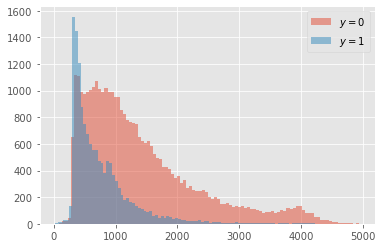

In [13]:
max_body_length = 5_000

bins=100
alpha=0.5

plt.hist(body_len_0[body_len_0 <= max_body_length], alpha=alpha, bins=bins, label=r'$y = 0$')
plt.hist(body_len_1[body_len_1 <= max_body_length], alpha=alpha, bins=bins, label=r'$y = 1$')
plt.legend();

отличаются ли медианы распределений?

In [14]:
np.median(body_len_0), np.median(body_len_1)

(1145.0, 601.0)

### Отличается ли распределение количества восклицательных знаков?

In [15]:
body_exclamation_0 = df[df.y == 0].body.str.count('!')
body_exclamation_1 = df[df.y == 1].body.str.count('!')

title_exclamation_0 = df[df.y == 0].title.str.count('!')
title_exclamation_1 = df[df.y == 1].title.str.count('!')

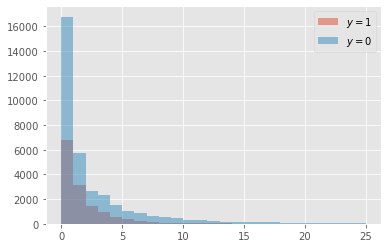

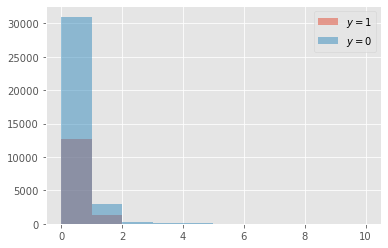

In [16]:
max_symbols = 25
title_max_symbols = 10

plt.hist(
    body_exclamation_1[body_exclamation_1 <= max_symbols],
    label=r'$y = 1$', bins=max_symbols, alpha=alpha
)
plt.hist(
    body_exclamation_0[body_exclamation_0 <= max_symbols],
    label=r'$y = 0$', bins=max_symbols, alpha=alpha
)
plt.legend()
plt.show()

plt.hist(
    title_exclamation_1[title_exclamation_1 <= title_max_symbols],
    label=r'$y = 1$', bins=title_max_symbols, alpha=alpha
)
plt.hist(
    title_exclamation_0[title_exclamation_0 <= title_max_symbols],
    label=r'$y = 0$', bins=title_max_symbols, alpha=alpha
)
plt.legend()
plt.show()

In [17]:
np.median(body_exclamation_0), np.median(body_exclamation_1)

(1.0, 1.0)

# Бейзлайн модель классификации

In [18]:
df['body_len'] = df.body.str.len()
df['title_len'] = df.title.str.len()
df['body_!'] = df.body.str.count('!')
df['title_!'] = df.title.str.count('!')

baseline_features = ['body_len', 'title_len', 'body_!', 'title_!']

In [19]:
df.head()

,body,title,rating,date,bank_name,y,body_len,title_len,body_!,title_!
0,Пользуюсь услугами банка около 4х лет.&amp;amp...,Очень эффективный банк,5,2020-10-02,Альфа-Банк,1,522,22,1,0
1,Несколько лет назад открыл кредитную карту в П...,Бешеные комиссии в Почта банке,1,2020-10-02,Почта Банк,0,1067,30,0,0
2,Решил закрыть карту этого банка. Через чат поп...,Ужасное обслуживание. Пустили по кругу,1,2020-10-02,Хоум Кредит Банк,0,725,38,0,0
3,"В марте 2020 года я потеряла работу , В конце ...",Сотрудники Сбербанка намерено меня обманули !!!!,1,2020-10-02,СберБанк,0,1332,48,1,4
4,"закончился вклад-депозит. во-первых, клиентски...",невозможно забрать свои же деньги,1,2020-10-02,Банк Открытие,0,1352,33,4,0


In [20]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=SEED)

In [21]:
x_train = df_train[baseline_features].values
y_train = df_train.y.values

x_val = df_val[baseline_features].values
y_val = df_val.y.values

In [22]:
baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=SEED, solver='lbfgs', class_weight='balanced'))
]).fit(x_train, y_train)

In [23]:
y_train_pred = baseline.predict(x_train)
f1_score(y_train, y_train_pred)

0.5599253973402529

In [24]:
y_val_pred = baseline.predict(x_val)
f1_score(y_val, y_val_pred)

0.5661788617886179

оцените важность признаков. проинтерпретируйте полученный результат

In [25]:
baseline_clf = baseline.steps[1][1]

In [26]:
baseline_features

['body_len', 'title_len', 'body_!', 'title_!']

In [27]:
baseline_clf.coef_

array([[-1.01917758, -0.46866134, -0.09123499,  0.02989326]])

In [28]:
baseline_clf.intercept_

array([-0.30513707])

# Обработка текста

## Модель на словах. CountVectorizer

In [29]:
stop_words = nltk.corpus.stopwords.words('russian')

In [30]:
count_model = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
            stop_words=stop_words, min_df=3, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced'))
])

In [31]:
x_train = df_train['body'].values
x_val = df_val['body'].values

In [32]:
count_model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.8, min_df=3,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...],
                                 token_pattern='[а-яё]+')),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log',
                               random_state=42))])

In [33]:
vectorizer = count_model.steps[0][1]

In [34]:
features = np.array(vectorizer.get_feature_names())

len(features)

41085

In [35]:
count_features = vectorizer.transform(x_train[[0]]).toarray()[0]

In [36]:
pd.DataFrame({
    'token': features[count_features > 0], 
    'count':count_features[count_features > 0]
})

,token,count
0,автокредита,1
1,банком,1
2,включена,1
3,воспользоваться,1
4,договора,1
5,дорогах,1
6,золотой,1
7,карту,1
8,ключ,1
9,кому,1


In [37]:
f1_score(y_train, count_model.predict(x_train))

0.9951080085747265

In [38]:
f1_score(y_val, count_model.predict(x_val))

0.9075194468452896

In [39]:
tree_model = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
            stop_words=stop_words, min_df=3, max_df=0.8
        )
    ),
    ('clf', DecisionTreeClassifier(random_state=SEED, criterion='entropy', max_depth=10))
])

обучите деревянную модель. сравните качество на тренировочном и валидационном наборах

In [40]:
tree_model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.8, min_df=3,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...],
                                 token_pattern='[а-яё]+')),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=42))])

In [41]:
f1_score(
    y_train,
    tree_model.predict(x_train)
)

0.8212472806381437

In [42]:
f1_score(
    y_val,
    tree_model.predict(x_val)
)

0.7915379130021393

In [43]:
clf = tree_model.steps[1][1]

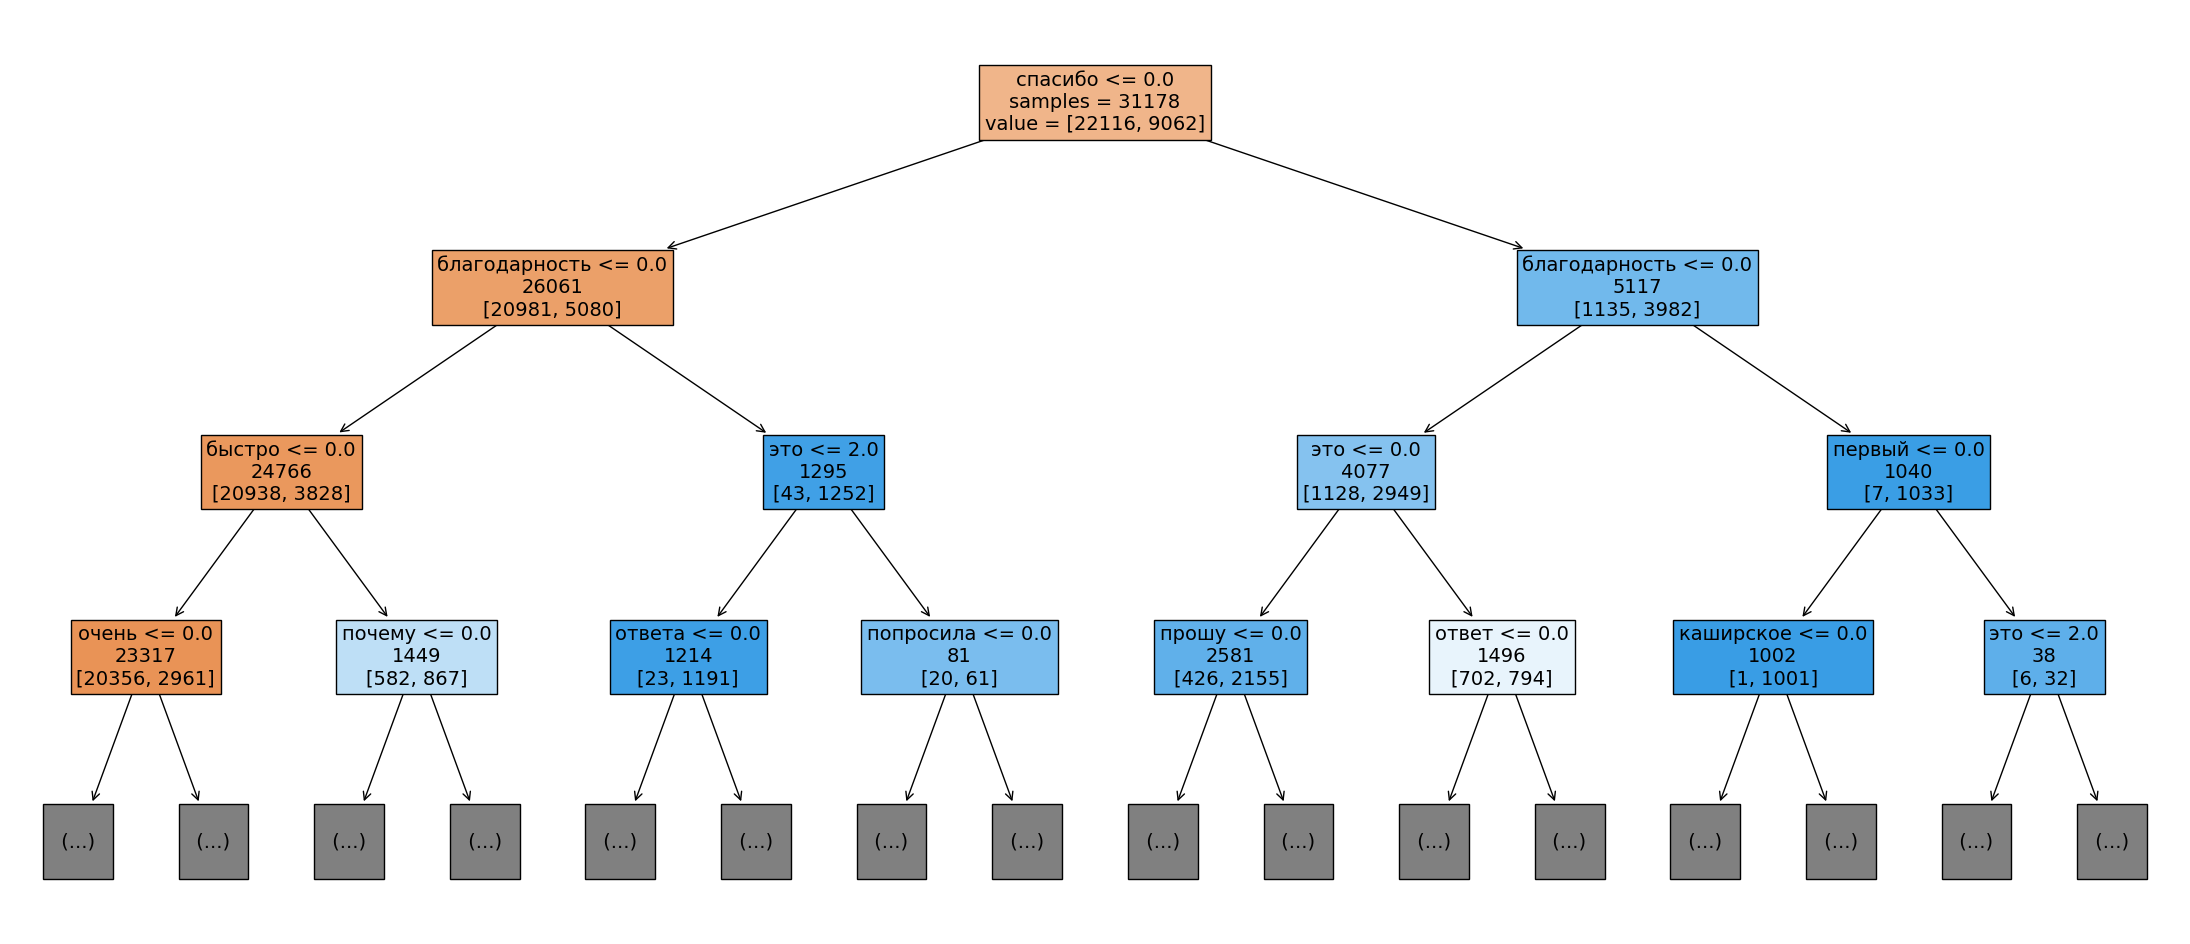

In [44]:
plt.style.use('default')
plt.figure(figsize=(28,12))
plot_tree(
    clf, max_depth=3, fontsize=14, filled=True, precision=0, label='root',
    impurity=False, feature_names=tree_model.steps[0][1].get_feature_names()
);

In [45]:
plt.style.use('ggplot')

## Модель на n-gram'ах символов. TfidfVectorizer

In [46]:
def preprocessor(text):
    whitespaced_text = re.sub("[^а-яё!:)(]", ' ', text.lower())
    return re.sub(' +', ' ',  whitespaced_text)

In [47]:
char_tfidf_model = Pipeline([
    (
        'vectorizer',
        TfidfVectorizer(
            lowercase=True, ngram_range=(2, 4), analyzer='char',
            preprocessor=preprocessor, min_df=5, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced'))
])

In [48]:
char_tfidf_model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', max_df=0.8, min_df=5,
                                 ngram_range=(2, 4),
                                 preprocessor=<function preprocessor at 0x7fdb0b0f8790>)),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log',
                               random_state=42))])

In [49]:
len(char_tfidf_model.steps[0][1].get_feature_names())

63817

In [50]:
weights = char_tfidf_model.steps[1][1].coef_[0]

In [51]:
feature_names = np.array(
    char_tfidf_model.steps[0][1].get_feature_names()
)

In [52]:
order = weights.argsort()

In [53]:
feature_names[order][-20:]

array(['лаг', 'ыстр', 'быс', 'быст', ' быс', 'бла', 'пас', 'дар', 'аго',
       'благ', 'лаго', ' спа', 'сиб', 'одар', 'спа', 'агод', 'паси',
       'асиб', 'сибо', 'спас'], dtype='<U4')

In [54]:
f1_score(y_train, char_tfidf_model.predict(x_train))

0.9359480028887284

In [55]:
f1_score(y_val, char_tfidf_model.predict(x_val))

0.9265687583444592

## Подбор параметров с помощью кросс-валидации

In [56]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75),
    'vectorizer__min_df': (3, 5, 7),
    'clf__alpha': (0.0001, 0.001, 0.01),
}

In [57]:
grid_search = GridSearchCV(count_model, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=1)

In [58]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_df=0.8, min_df=3,
                                                        stop_words=['и', 'в',
                                                                    'во', 'не',
                                                                    'что', 'он',
                                                                    'на', 'я',
                                                                    'с', 'со',
                                                                    'как', 'а',
                                                                    'то', 'все',
                                                                    'она',
                                                                    'так',
                                                                    'его', 'но',
                                                            

In [59]:
best_parameters = grid_search.best_estimator_.get_params()

In [60]:
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__alpha: 0.001
	vectorizer__max_df: 0.5
	vectorizer__min_df: 3


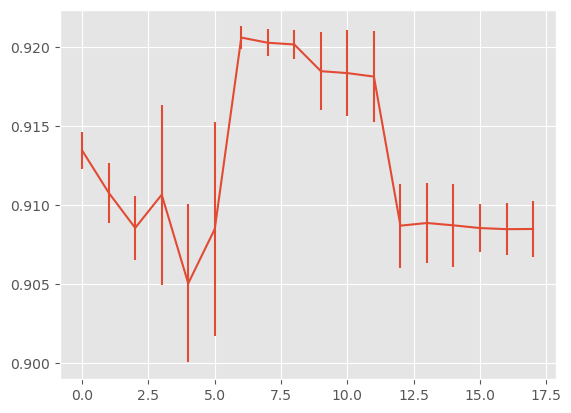

In [61]:
mean_score = grid_search.cv_results_['mean_test_score']
std_score = grid_search.cv_results_['std_test_score']
x = np.arange(0, mean_score.size)

plt.errorbar(x, mean_score, yerr=std_score);

In [62]:
grid_search.cv_results_

{'mean_fit_time': array([10.29240203,  9.93320092,  9.33298866,  8.61316697,  8.56449835,
         9.04837235, 10.29360263, 10.72281297, 12.75137003, 13.27719307,
        12.80647333, 12.75358701, 13.44075505, 14.44359636, 14.61906266,
        14.50683403, 13.37593301, 14.14462868]),
 'std_fit_time': array([0.05498928, 0.11244737, 0.75014529, 0.06849127, 0.12526777,
        0.61764692, 0.20043179, 0.07313499, 0.32430263, 0.05494238,
        0.33912285, 0.34495736, 0.18626347, 0.69154259, 0.14581059,
        0.2935613 , 0.11987774, 0.28159463]),
 'mean_score_time': array([4.38305783, 4.0392491 , 3.39879767, 3.35636346, 3.35641797,
        4.52257498, 5.07677571, 5.13825401, 5.61646859, 5.18582193,
        5.63483763, 6.87420026, 7.36451785, 7.1202747 , 6.3408734 ,
        5.47040399, 7.28444131, 6.3157359 ]),
 'std_score_time': array([0.10100748, 0.13487564, 0.09597968, 0.02425343, 0.00779666,
        0.82868536, 0.06254812, 0.0943063 , 0.3229722 , 0.0225794 ,
        0.62748153, 0.0566

In [63]:
cv_tuned_pipeline = grid_search.best_estimator_

In [64]:
f1_score(
    y_train,
    cv_tuned_pipeline.predict(x_train)
)

0.9601796571178178

In [65]:
f1_score(
    y_val,
    cv_tuned_pipeline.predict(x_val)
)

0.9145466405740378

## Объединение признаков

In [66]:
pipeline = Pipeline([
    (
        'features', 
        ColumnTransformer([
            (
                'title', 
                TfidfVectorizer(
                    lowercase=True, ngram_range=(1, 2), token_pattern=TOKEN_PATTERN,
                    stop_words=stop_words, min_df=5, max_df=0.75
                ), 
                'title'
            ),
            (
                'body',
                CountVectorizer(
                    lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
                    stop_words=stop_words, min_df=3, max_df=0.75
                ), 
                'body'
            )
        ])
    ),
    ('clf', SGDClassifier(random_state=SEED, alpha=0.01))
])

In [67]:
pipeline.fit(df_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('title',
                                                  TfidfVectorizer(max_df=0.75,
                                                                  min_df=5,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['и',
                                                                              'в',
                                                                              'во',
                                                                              'не',
                                                                              'что',
                                                                              'он',
                                                                              'на',
     

In [68]:
f1_score(
    y_train,
    pipeline.predict(df_train)
)

0.9442055163713515

In [69]:
f1_score(
    y_val,
    pipeline.predict(df_val)
)

0.9216272121351414

получите признаки из векторизатора. посмотрите на добавленные биграммы

In [70]:
vectorizer = pipeline["features"].named_transformers_["title"]

In [71]:
vectorizer.get_feature_names()

['абсолют',
 'абсолютная',
 'абсолютная некомпетентность',
 'абсолютно',
 'абсолютно неклиентоориентированный',
 'абсолютно некомпетентные',
 'абсолютное',
 'абсолютный',
 'авиабилеты',
 'авто',
 'автозаводской',
 'автокредит',
 'автокредита',
 'автокредиту',
 'автомобиль',
 'автомобиля',
 'ад',
 'ада',
 'адекватный',
 'адрес',
 'адресу',
 'аижк',
 'ак',
 'ак барс',
 'аккредитив',
 'аккредитива',
 'аккредитиву',
 'активации',
 'активация',
 'активация карты',
 'активировать',
 'активировать карту',
 'активный',
 'акцией',
 'акции',
 'акции приведи',
 'акций',
 'акция',
 'акция приведи',
 'альфа',
 'альфа банк',
 'альфа банка',
 'альфа банке',
 'альфа банком',
 'альфа банку',
 'альфа чек',
 'альфабанк',
 'альфе',
 'аннулирование',
 'ао',
 'ао альфа',
 'ао россельхозбанк',
 'апреля',
 'арест',
 'арест счета',
 'ареста',
 'б',
 'базы',
 'баланс',
 'баланса',
 'баллов',
 'баллы',
 'банк',
 'банк банк',
 'банк берет',
 'банк бизнеса',
 'банк вводит',
 'банк вернул',
 'банк возвращает',
 'ба

## Визуализация отзывов

Мы обучали модель классификации с помощью бинарной кросс-энтропии (log_loss):
$$
L = - y \log\left(\hat{y}\right) - (1 - y) \log\left(1 - \hat{y}\right)
$$

первое слагаемое в функции потерь отвечает за ложно-положительные срабатывания, второе — за ложно-отрицательные

посмотрим, на каких примерах полученная модель сильнее всего ошибается в одну и другую сторону

In [72]:
y_val_proba = count_model.predict_proba(x_val)[:, 1]

y_val_rating = df_val.reset_index().rating.values

In [73]:
def false_positive(y, y_proba, eps=1e-15):
    if y:
        return (-y) * np.log(y_proba + eps)
    else:
        return 0.0

def false_negative(y, y_proba, eps=1e-15):
    if y:
        return 0.0
    else:
        return (y - 1) * np.log(1 - y_proba + eps)


review_count = 5


positive_error = np.array([false_positive(y, y_proba) for (y, y_proba) in zip(y_val, y_val_proba)])

negative_error = np.array([false_negative(y, y_proba) for (y, y_proba) in zip(y_val, y_val_proba)])

max_loss_ids = np.concatenate((
    positive_error.argsort()[::-1][:review_count],
    negative_error.argsort()[::-1][:review_count]
))

In [74]:
vectorizer = count_model.steps[0][1]

token2id = {token: i for i, token in enumerate(vectorizer.get_feature_names())}

importance = count_model.steps[1][1].coef_[0]

min_importance = importance.min()
max_importance = importance.max()

In [75]:
for i in max_loss_ids:
    review_body = x_val[i]
    
    print(f'rating: {y_val_rating[i]}')
    print(f'predicted proba: {y_val_proba[i]}')
    
    review_tokens = re.findall(TOKEN_PATTERN, review_body.lower())
    
    html_string = '''
    <p style="font-size:16px; color:#000000; border: 2px solid #000; text-align: justify; background-color:#ffffff; border-radius: 25px; padding: 20px;">
    '''

    for token in review_tokens:
        if token in token2id:
            weight = importance[token2id[token]]
            if weight < 0:
                component = hex(int(255 - 255 * weight / min_importance))[2:]
                color = f'{component}{component}ff'
            else:
                component = hex(int(255 - 255 * weight / max_importance))[2:]
                color = f'ff{component}{component}'
        else:
            weight = 0.0
            color = 'ffffff'
        html_string += f'<span style="background-color: #{color}"; title="{weight:.2f}">{token}</span> '

    html_string += '</p>'

    display(HTML(html_string))

rating: 5
predicted proba: 2.730241377105066e-10


rating: 4
predicted proba: 1.7047224163873442e-08


rating: 5
predicted proba: 6.097717358665765e-08


rating: 4
predicted proba: 1.0147657854859243e-06


rating: 4
predicted proba: 1.2162001458849035e-06


rating: 1
predicted proba: 0.9996527536516763


rating: 1
predicted proba: 0.9988035246131061


rating: 1
predicted proba: 0.998653195578374


rating: 1
predicted proba: 0.9986151120201464


rating: 2
predicted proba: 0.9978225222466653


если присмотреться, то ошибки модели связаны с ошибками в разметке

# Проблемы анализа тональности

это двойные отрицания и сарказм

In [76]:
sentences = [
    'ну да, блин, отношение к клиентам супер, спасибо вам...',
    'такой клиентоориентированности я еще не видел, сказочные ...',
    'выражаю огромную благодарность банку, третий раз пытаюсь оформить доставку карты, но воз и ныне там',
    'я думал, что банк окажется хуже некуда, но обошлось',
    'раньше ненавидел сбербанк, а теперь всем советую'
]

labels = [0, 0, 0, 1, 1]

predictions = count_model.predict_proba(sentences)[:, 1]


for sentence, label, prediction in zip(sentences, labels, predictions):
    print(sentence)
    print(f"TRUE: {label} PREDICTED: {prediction:.2f}\n")
    print("#" * 100, end='\n\n')

ну да, блин, отношение к клиентам супер, спасибо вам...
TRUE: 0 PREDICTED: 0.89

####################################################################################################

такой клиентоориентированности я еще не видел, сказочные ...
TRUE: 0 PREDICTED: 0.61

####################################################################################################

выражаю огромную благодарность банку, третий раз пытаюсь оформить доставку карты, но воз и ныне там
TRUE: 0 PREDICTED: 0.95

####################################################################################################

я думал, что банк окажется хуже некуда, но обошлось
TRUE: 1 PREDICTED: 0.51

####################################################################################################

раньше ненавидел сбербанк, а теперь всем советую
TRUE: 1 PREDICTED: 0.39

####################################################################################################

